### 2 Model Creation (8 points)

Given features Xi of player i, we want to predict $Y_i = N_{i,red} / N_i$, the fraction of games where the player will receive a red card. We will solve this problem using two model types: linear regression and regression forests.

Implement both models and determine their squared test errors by means of cross-validation. Alternatively (or in addition to this will result in bonus points), you can also try to predict $Y_i = p(red | X_i)$ via the posterior of a classification model.

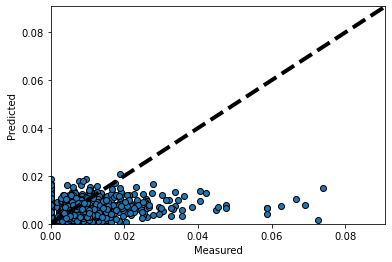

In [11]:
# Linear Regression

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict

LR_model = LinearRegression()
#LR_model.fit(X=features, y =redCards)

#LR_MSE = np.square(LR_model.predict(X=features) - redCards).sum()
#display(Markdown('Linear Regression MSE score = {:f}'.format(LR_MSE)))

#prediction = LR_model.predict(X=features)
#plt.plot(prediction-redCards,color='blue',marker='.',linewidth=0)
#plt.title("Linear Regression - delta between prediction and actual")
#plt.xlabel('player index')
#plt.ylabel('$N_{i,red} / N_i$')

predicted = cross_val_predict(LR_model, X=features, y=redCards, cv=10)
fig, ax = plt.subplots()
ax.scatter(redCards, predicted, edgecolors=(0, 0, 0))
ax.plot([redCards.min(), redCards.max()], [redCards.min(), redCards.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_xlim((redCards.min(), redCards.max()))
ax.set_ylim((redCards.min(), redCards.max()))

plt.show()

In [14]:
# Regression Forest

class Node:
    def __init__(self):
        pass 

class Tree:
    def __init__(self):
        self.root = Node()
    
    def find_leaf(self, x):
        node = self.root
        while hasattr(node, "feature"): # leaf node has no 'feature' attribute
            j = node.feature
            if x[j] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node

    
class RegressionTree(Tree):
    def __init__(self):
        super(RegressionTree, self).__init__()
        
    def train(self, data, labels, n_min=20):
        '''
        data: the feature matrix for all digits
        labels: the corresponding ground-truth responses
        n_min: termination criterion (don't split if a node contains fewer instances)
        '''
        N, D = data.shape
        D_try = int(np.sqrt(D)) # how many features to consider for each split decision

        # initialize the root node
        self.root.data = data
        self.root.labels = labels
        
        stack = [self.root]
        while len(stack): 
            node = stack.pop()    # check the last node on the stack
            
            #print("Node >>> ", node.data.shape)
            
            n = node.data.shape[0]    # number of instances in present node
            if(n >= n_min):
                # Call 'make_regression_split_node()' with 'D_try' randomly selected feature indices. 
                # This turns 'node' into a split node and returns the two children, which must be placed on the 'stack'.
                feature_indices = np.random.permutation(D)[:D_try]
                left, right = make_regression_split_node(node, feature_indices)
                if left is not None:
                    stack.append(left)
                    stack.append(right)
            else:
                # Call 'make_regression_leaf_node()' to turn 'node' into a leaf node.
                if (node.labels.size > 0):
                    make_regression_leaf_node(node)
                
                
    def predict(self, x): # here x is single data point        
        leaf = self.find_leaf(x)
        return leaf.response 
    

def make_regression_split_node(node, feature_indices):
    '''
    node: the node to be split
    feature_indices: a numpy array of length 'D_try', containing the feature 
                     indices to be considered in the present split
    '''
    n, D = node.data.shape

    # find best feature j (among 'feature_indices') and best threshold t for the split
    e_min = float("inf")
    j_min, t_min = 0, 0
    
   #for all features
    for j in feature_indices:
        # Hint: For each feature considered, first remove duplicate feature values using 
        # 'np.unique()'. 
        # This is necessary because candidate thresholds should be in the middle between 
        # consecutive feature values, not at any of the feature values.

        # remove duplicate features
        dj = np.sort(np.unique(node.data[:,j])) 
        # compute candidate thresholds in the middle between consecutive feature values
        tj = (dj[1:] + dj[:-1]) / 2
        
        # each candidate threshold we need to compute leave-one-out error (looErr) of the resulting children node
        for t in tj:
            # compute the number of instances in left and right node 
            nl = np.sum(node.data[:,j] <= t) 
            ll = node.labels[node.data[:,j] <= t]
            nr = n - nl
            lr = node.labels[node.data[:,j] > t]
            
            el = ((ll-ll.mean())**2).sum()
            er = ((lr-lr.mean())**2).sum()
            # choose the best threshold that minimizes sum of looErr
            loo_error = el + er
            if loo_error < e_min:
                e_min = loo_error
                j_min = j
                t_min = t


    # create children
    left = Node()
    right = Node()
    
    # initialize 'left' and 'right' with the data subsets and bounding boxes
    # according to the optimal split found above
    left.data = node.data[node.data[:,j_min] <= t_min, :]
    left.labels = node.labels[node.data[:,j_min] <= t_min]
    right.data = node.data[node.data[:,j_min] > t_min, :]
    right.labels = node.labels[node.data[:,j_min] > t_min]
    
    # turn the current 'node' into a split node
    # (store children and split condition)
    node.left = left
    node.right = right
    node.feature = j_min
    node.threshold = t_min

    # return the children (to be placed on the stack)
    return left, right 


def make_regression_leaf_node(node):
    '''
    node: the node to become a leaf
    '''
    # compute and store leaf response
    node.N = node.labels.shape[0]

    # The response of leaf bl is the average response of the training instances assigned to this leaf
    node.response = node.labels.mean()
    


(1419, 120)

(1419,)

Text(0, 0.5, '$N_{i,red} / N_i$')

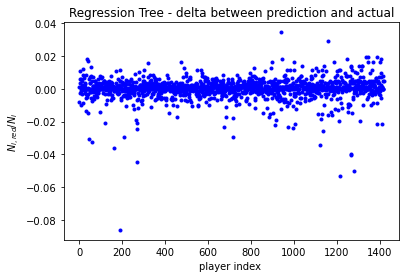

In [19]:
data = features.to_numpy()
labels = redCards.to_numpy()

display(data.shape, labels.shape)
regression_tree = RegressionTree()
regression_tree.train(data, labels)


predictions = []
for x in data:
    predictions.append(regression_tree.predict(x))

plt.plot(np.array(predictions)-redCards,color='blue',marker='.',linewidth=0)
plt.title("Regression Tree - delta between prediction and actual")
plt.xlabel('player index ')
plt.ylabel('$N_{i,red} / N_i$')
